In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Импорт "сырых" данных

In [63]:
raw_xls = pd.read_csv('https://raw.githubusercontent.com/RusinDima12/BSR/main/data/raw_from_xls.csv')
raw_xls.head()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,49.0,0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0,0,0,0,0,1,NaN,0,0.0,0.0
1,65.0,0,0.0,1.0,2.0,1.0,NaN,2.0,0.0,NaN,...,0,0,0,1,0,0,0.0,0,0.0,0.0
2,58.0,1,0.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.0,0,0.0,0.0
3,43.0,1,4.0,2.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0.0,0.0
4,49.0,1,0.0,4.0,2.0,1.0,NaN,2.0,0.0,3.0,...,0,0,0,0,0,0,0.0,0,0.0,0.0


# Анализ качества данных (пропуски, выбросы)

In [34]:
print('Число записей БД:', raw_xls.shape[0])
print('Число полей БД:', raw_xls.shape[1])

Число записей БД: 1700
Число полей БД: 123


In [64]:
target_columns = ['LET_IS']
target_columns_new = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 
                 'A_V_BLOK', 'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN'
                 , 'REC_IM', 'P_IM_STEN']
inputs_columns = raw_xls.drop(columns=['LET_IS']).columns.values
raw_xls['DEATH'] = raw_xls['LET_IS'].apply(lambda x: 1 if x > 0 else 0)

In [65]:
death_dict = {1: 'Кардиогенный шок',
2: 'Отек легких',
3: 'Разрыв сердца',
4: 'Прогрессирование застойной сердечн. недостаточности',
5: 'Тромбоэмболия',
6: 'Асистолия',
7: 'фибрилляция желудочков'}

In [67]:
zero_day = ['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG'
             ,'ZSN_A', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
             , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
             , 'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST'
             , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P'
             , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
             , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08'
             , 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06'
             , 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
             , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'K_BLOOD'
             , 'GIPER_NA', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S', 'NA_KB'
             , 'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n'
             , 'TRENT_S_n','LET_IS']

one_day = ['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG'
             ,'ZSN_A', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
             , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
             , 'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST'
             , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P'
             , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
             , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08'
             , 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06'
             , 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
             , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'K_BLOOD'
             , 'GIPER_NA', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S', 'NA_KB'
             , 'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n'
             , 'TRENT_S_n', 'R_AB_1_n', 'NA_R_1_n', 'NOT_NA_1_n','DEATH']

two_day = ['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG'
             ,'ZSN_A', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
             , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
             , 'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST'
             , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P'
             , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
             , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08'
             , 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06'
             , 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
             , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'K_BLOOD'
             , 'GIPER_NA', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S', 'NA_KB'
             , 'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n'
             , 'TRENT_S_n', 'R_AB_1_n', 'R_AB_2_n', 'NA_R_1_n', 'NA_R_2_n', 'NOT_NA_1_n', 'NOT_NA_2_n','DEATH']

three_day = ['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG'
             ,'ZSN_A', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
             , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
             , 'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST'
             , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P'
             , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
             , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08'
             , 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06'
             , 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
             , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'K_BLOOD'
             , 'GIPER_NA', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S', 'NA_KB'
             , 'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n'
             , 'TRENT_S_n', 'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_1_n'
             , 'NOT_NA_2_n', 'NOT_NA_3_n','DEATH']

In [68]:
raw_xls['LET_IS'].unique()

array([ 0.,  3.,  7.,  5.,  2.,  4.,  1., nan,  6.])

In [81]:
zero_day_data = raw_xls[zero_day].copy()
one_day_data = raw_xls[one_day].copy()
two_day_data = raw_xls[two_day].copy()
three_day_data = raw_xls.iloc[:,0:111].copy()
three_day_data['DEATH'] = raw_xls['DEATH']

In [70]:
zero_day_data

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
0,49.0,0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,65.0,0,0.0,1.0,2.0,1.0,NaN,2.0,0.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,58.0,1,0.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,43.0,1,4.0,2.0,2.0,2.0,NaN,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,49.0,1,0.0,4.0,2.0,1.0,NaN,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,62.0,1,0.0,0.0,0.0,0.0,NaN,0.0,1.0,7.0,...,NaN,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0
1696,70.0,0,0.0,2.0,2.0,1.0,NaN,2.0,0.0,7.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,7.0,...,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1698,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,7.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [8]:
raw_xls.iloc[:,0:111]

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
0,49.0,0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,65.0,0,0.0,1.0,2.0,1.0,NaN,2.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,58.0,1,0.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,43.0,1,4.0,2.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,49.0,1,0.0,4.0,2.0,1.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,62.0,1,0.0,0.0,0.0,0.0,NaN,0.0,1.0,7.0,...,2.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1696,70.0,0,0.0,2.0,2.0,1.0,NaN,2.0,0.0,7.0,...,1.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,7.0,...,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1698,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,7.0,...,1.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0


## Пропуски

Поля без пропусков

In [71]:
raw_xls.isnull().sum()[raw_xls.isnull().sum()==0]

SEX           0
PREDS_TAH     0
JELUD_TAH     0
FIBR_JELUD    0
A_V_BLOK      0
OTEK_LANC     0
RAZRIV        0
DRESSLER      0
REC_IM        0
DEATH         0
dtype: int64

Количество пропусков по всем переменным

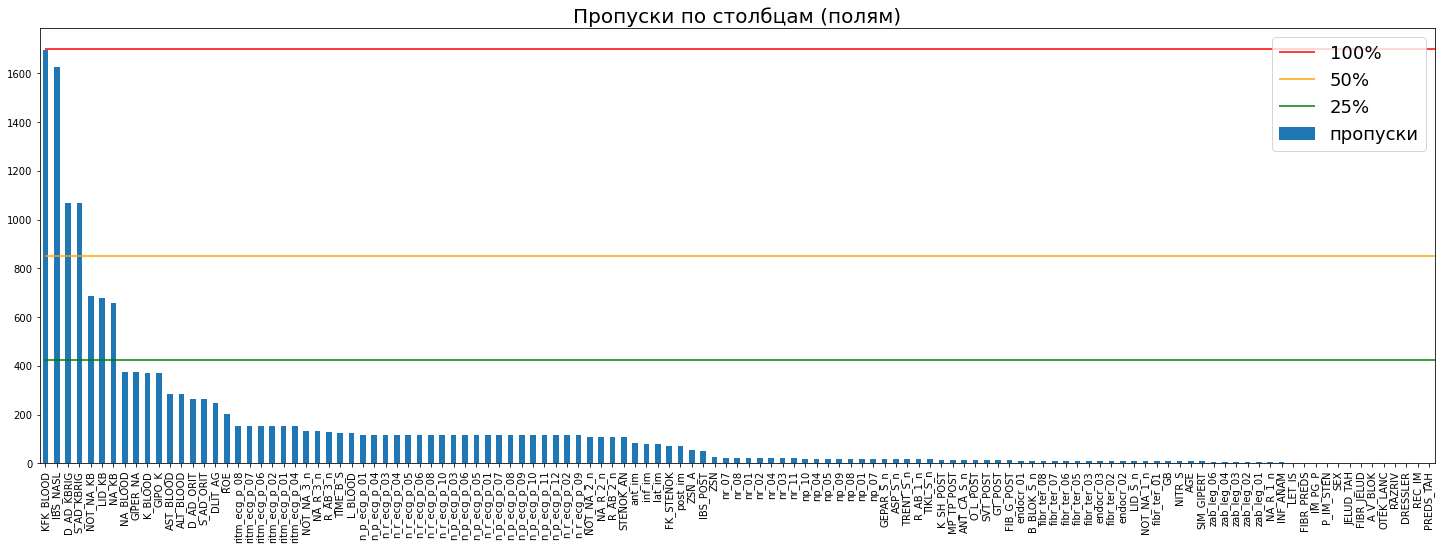

In [59]:
fig, ax = plt.subplots(figsize=(25,8))
raw_xls.isnull().sum().sort_values(ascending=False).plot(kind='bar',  ax=ax, label='пропуски')
ax.hlines(raw_xls.shape[0], 0, raw_xls.shape[1], color='red', label='100%')
ax.hlines(int(raw_xls.shape[0]/2), 0, raw_xls.shape[1], color='orange', label='50%')
ax.hlines(int(raw_xls.shape[0]/4), 0, raw_xls.shape[1], color='green', label='25%')
ax.legend(fontsize=18)
ax.set_title('Пропуски по столбцам (полям)', fontsize=20)
plt.show()

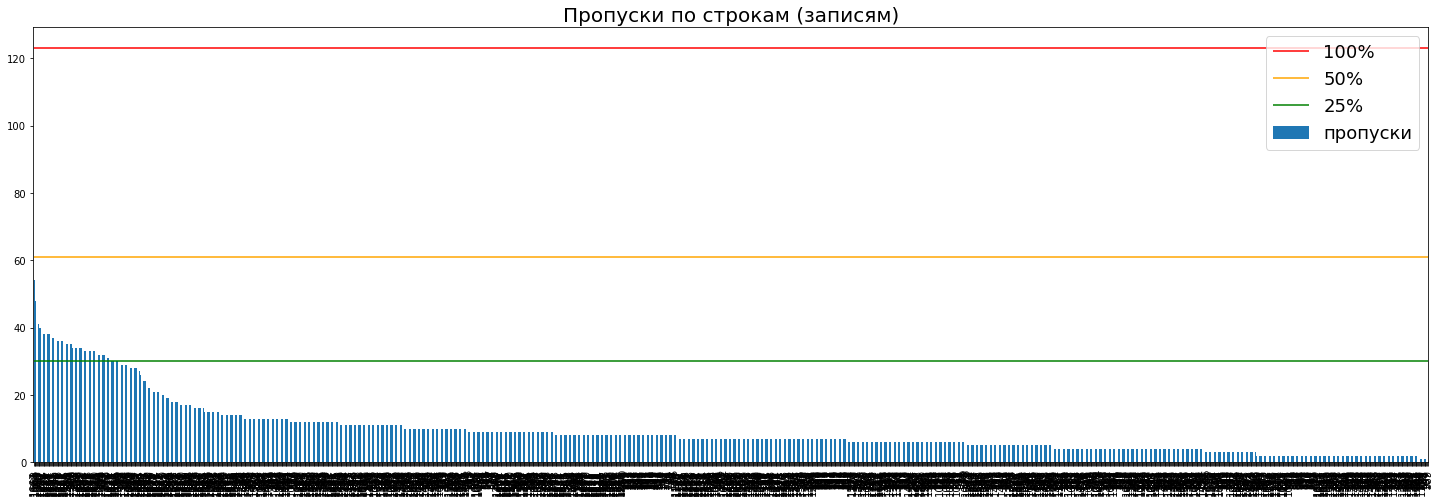

In [60]:
fig, ax = plt.subplots(figsize=(25,8))
raw_xls.isnull().sum(axis=1).sort_values(ascending=False).plot(kind='bar',  ax=ax, label='пропуски')
ax.hlines(raw_xls.shape[1], 0, raw_xls.shape[0], color='red', label='100%')
ax.hlines(int(raw_xls.shape[1]/2), 0, raw_xls.shape[0], color='orange', label='50%')
ax.hlines(int(raw_xls.shape[1]/4), 0, raw_xls.shape[0], color='green', label='25%')
ax.legend(fontsize=18)
ax.set_title('Пропуски по строкам (записям)', fontsize=20)
plt.show()

<AxesSubplot:>

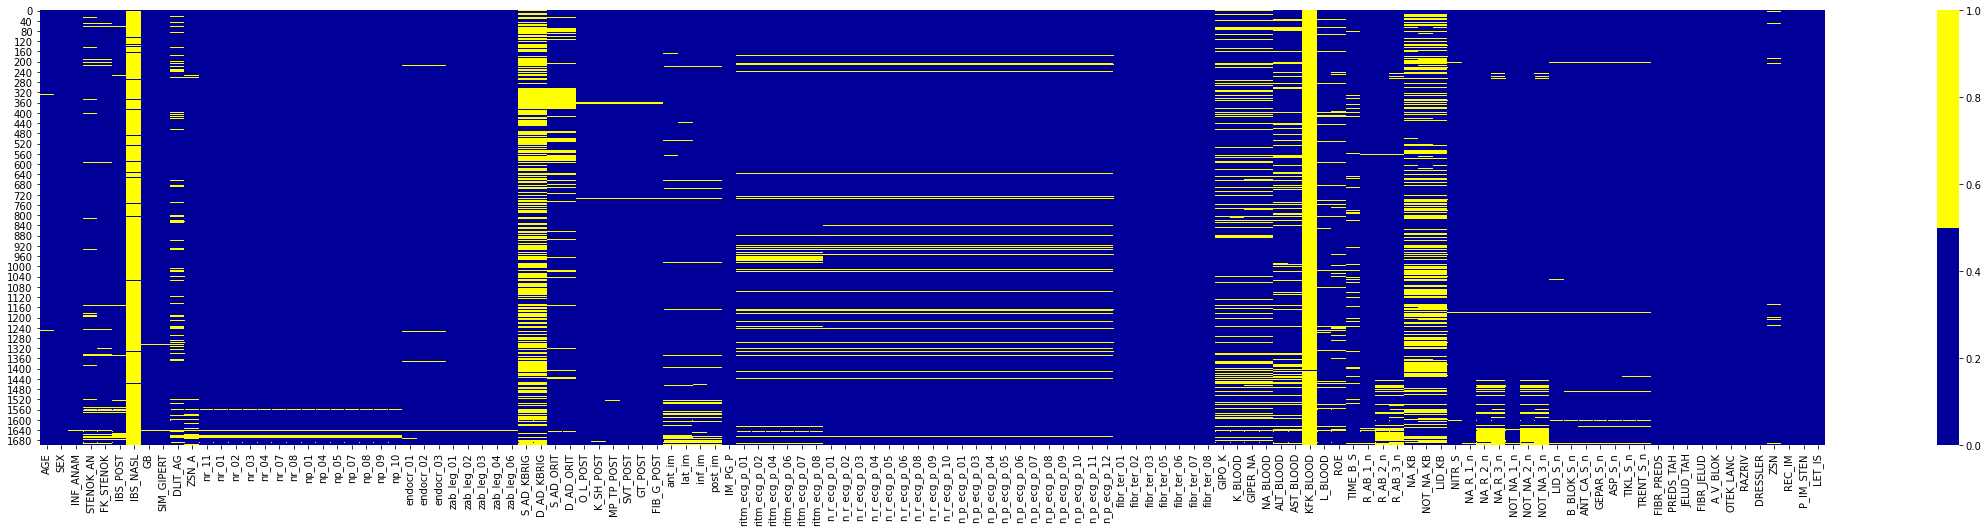

In [61]:
cols = raw_xls.columns 
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
plt.figure(figsize=(40, 8))
sns.heatmap(raw_xls[cols].isnull(), cmap=sns.color_palette(colours))

TODO: попробовать разные методы:

* БД без столбцов/строк где много пропусков
* заполнить средним/модой
* kNN

Удаление строк где пропусков > 25%

Удаление столбцов где пропусков > 50%

In [72]:
def drop_rows_columns(dataFrame):
    dataFrame = dataFrame.drop(dataFrame.loc[dataFrame.isnull().sum(axis=1).sort_values(ascending=False)>dataFrame.shape[1]/4].index)
    for column in dataFrame.columns:
        if dataFrame[column].isnull().sum()>dataFrame.shape[0]/2 and column not in target_columns_new :
            del dataFrame[column]
    return dataFrame

In [82]:
zero_day_data = drop_rows_columns(zero_day_data)
one_day_data = drop_rows_columns(one_day_data)
two_day_data = drop_rows_columns(two_day_data)
three_day_data = drop_rows_columns(three_day_data)

In [74]:
zero_day_data

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
0,49.0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,65.0,0,0.0,1.0,2.0,1.0,2.0,0.0,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,58.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,43.0,1,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,49.0,1,0.0,4.0,2.0,1.0,2.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,62.0,1,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,...,NaN,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0
1696,70.0,0,0.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,...,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1698,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,NaN,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


## Категориальные/числовые данные

In [47]:
numeric_features = ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD'
                    ,'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE']#'KFK_BLOOD'
categorical_features = ['SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK'
                        , 'IBS_POST', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A'
                        ,'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07'
                        , 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
                        , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02'
                        , 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
                        , 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST'
                        , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST'
                        , 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P'
                        , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04'
                        , 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
                        , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03'
                        , 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06'
                        , 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10'
                        , 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04'
                        , 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07'
                        , 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10'
                        , 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
                        , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05'
                        , 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08'
                        ,'GIPO_K', 'GIPER_NA', 'TIME_B_S', 'R_AB_1_n'
                        , 'R_AB_2_n', 'R_AB_3_n', 'NA_KB', 'NOT_NA_KB'
                        , 'LID_KB', 'NITR_S', 'NA_R_1_n', 'NA_R_2_n'
                        , 'NA_R_3_n', 'NOT_NA_1_n', 'NOT_NA_2_n'
                        , 'NOT_NA_3_n', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n'
                        , 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n']
numeric_features_int = ['AGE', 'S_AD_ORIT','D_AD_ORIT','NA_BLOOD','ROE']
binary_features = ['SEX', 'IBS_NASL', 'SIM_GIPERT','nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04'
                   , 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
                   , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02'
                   , 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
                   , 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST'
                   , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST','IM_PG_P'
                   , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04'
                   , 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
                   , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03'
                   , 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06'
                   , 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10'
                   , 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04'
                   , 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07'
                   , 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10'
                   , 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
                   , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05'
                   , 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08'
                   ,'GIPO_K', 'GIPER_NA', 'NA_KB', 'NOT_NA_KB', 'LID_KB'
                   , 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n'
                   , 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n',]

In [48]:
set_difference = set(categorical_features).symmetric_difference(set(binary_features))
list_difference = list(set_difference)

In [14]:
list_difference

['NA_R_3_n',
 'INF_ANAM',
 'DLIT_AG',
 'NOT_NA_1_n',
 'IBS_POST',
 'NOT_NA_2_n',
 'IBS_NASL',
 'R_AB_1_n',
 'R_AB_3_n',
 'NOT_NA_3_n',
 'lat_im',
 'STENOK_AN',
 'R_AB_2_n',
 'FK_STENOK',
 'NA_R_2_n',
 'ZSN_A',
 'ant_im',
 'inf_im',
 'GB',
 'post_im',
 'TIME_B_S',
 'NA_R_1_n']

In [18]:
raw_xls[numeric_features].head()

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE
0,49.0,120.0,70.0,3.9,130.0,0.23,0.26,5.7,7.0
1,65.0,140.0,80.0,3.9,140.0,NaN,NaN,9.1,5.0
2,58.0,140.0,80.0,NaN,NaN,0.38,0.15,9.0,5.0
3,43.0,120.0,80.0,4.3,136.0,0.75,0.48,9.9,3.0
4,49.0,130.0,90.0,3.6,136.0,0.52,0.30,8.1,2.0


Заполнение средним числовые данные

In [15]:
def average_data(dataframe):
    avg_data = dataframe.copy()
    list_columns = list(dataframe.columns)
    for i in numeric_features:
        if i in list_columns:
            if i in numeric_features_int:
                avg_data[i]=avg_data[i].fillna(int(avg_data[i].mean()))
            else:
                avg_data[i]=avg_data[i].fillna(avg_data[i].mean())

    for i in categorical_features:
        if i in list_columns: 
            avg_data[i]=avg_data[i].fillna(int(avg_data[i].mean()))
    return avg_data

In [16]:
avg_zero_day_data = average_data(zero_day_data)
avg_one_day_data = average_data(one_day_data)
avg_two_day_data = average_data(two_day_data)
avg_three_day_data = average_data(three_day_data)

In [62]:
avg_zero_day_data.describe()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,NOT_NA_KB,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
count,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,...,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000
mean,61.633883,0.628807,0.548223,2.274112,1.191624,1.154822,1.385787,0.031091,3.268401,0.189086,...,0.416244,0.231599,0.117386,0.288071,0.127538,0.667513,0.708122,0.742386,0.018401,0.199873
std,11.322453,0.483277,0.892414,2.367985,1.037130,0.792914,1.088888,0.173620,2.878433,0.653028,...,0.494377,0.421988,0.401017,0.453008,0.333681,0.471254,0.454771,0.437459,0.134439,0.400032
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,70.000000,1.000000,1.000000,5.000000,2.000000,2.000000,2.000000,0.000000,7.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,92.000000,1.000000,6.000000,6.000000,8.000000,2.000000,3.000000,1.000000,10.000000,4.000000,...,2.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Заполнение модой

In [17]:
def moda_data(dataframe):
    list_columns = list(dataframe.columns)
    moda_data = dataframe.copy()
    for i in numeric_features:
        if i in list_columns:
            moda_data[i]=moda_data[i].fillna(moda_data[i].mode().values[0])
    for i in categorical_features:
        if i in list_columns:
            moda_data[i]=moda_data[i].fillna(moda_data[i].mode().values[0])
    return moda_data

In [18]:
moda_zero_day_data = moda_data(zero_day_data)
moda_one_day_data = moda_data(one_day_data)
moda_two_day_data = moda_data(two_day_data)
moda_three_day_data = moda_data(three_day_data)

In [66]:
moda_zero_day_data.describe()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,NOT_NA_KB,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
count,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,...,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000
mean,61.642766,0.628807,0.548223,2.163706,1.229061,1.179569,1.387690,0.031091,2.853426,0.189086,...,0.815355,0.231599,0.117386,0.288071,0.127538,0.675761,0.718909,0.753173,0.018401,0.199873
std,11.322737,0.483277,0.892414,2.424186,1.047540,0.803240,1.089086,0.173620,3.095428,0.653028,...,0.389765,0.421988,0.401017,0.453008,0.333681,0.468238,0.449675,0.431302,0.134439,0.400032
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,62.500000,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,70.000000,1.000000,1.000000,5.000000,2.000000,2.000000,2.000000,0.000000,7.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,92.000000,1.000000,6.000000,6.000000,8.000000,2.000000,3.000000,1.000000,10.000000,4.000000,...,2.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Заполнение методом KNN

In [83]:
imputer = KNNImputer(n_neighbors=5)
knn_zero_day_data = pd.DataFrame(imputer.fit_transform(zero_day_data),columns = zero_day_data.columns)
knn_one_day_data = pd.DataFrame(imputer.fit_transform(one_day_data),columns = one_day_data.columns)
knn_two_day_data = pd.DataFrame(imputer.fit_transform(two_day_data),columns = two_day_data.columns)
knn_three_day_data = pd.DataFrame(imputer.fit_transform(three_day_data),columns = three_day_data.columns)

In [84]:
knn_zero_day_data

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
0,49.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,65.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,3.8,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,58.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,43.0,1.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.6,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,49.0,1.0,0.0,4.0,2.0,1.0,2.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,62.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,...,0.6,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0
1572,70.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
1573,70.0,0.0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1574,79.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [76]:
def Normalization (dataframe):
    for column in dataframe.columns:
        dataframe[column] =(dataframe[column] - dataframe[column].min()) / (dataframe[column].max() - dataframe[column].min()) 
    return dataframe

In [59]:
knn_zero_day_data.to_csv('knn_zero_day_data2withOther answers.csv',index = False)

In [79]:
knn_zero_day_data.to_csv('../data/zero/knn_zero_day_data_let_is.csv',index = False)

In [80]:
knn_zero_day_data

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
0,0.348485,0.0,0.000000,0.000000,0.00,1.0,0.000000,0.0,0.00,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
1,0.590909,0.0,0.000000,0.166667,0.25,0.5,0.666667,0.0,0.38,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000
2,0.484848,1.0,0.000000,0.000000,0.00,1.0,0.666667,0.0,0.20,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000
3,0.257576,1.0,0.666667,0.333333,0.25,1.0,0.000000,0.0,0.00,0.0,...,0.6,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.000000
4,0.348485,1.0,0.000000,0.666667,0.25,0.5,0.666667,0.0,0.30,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.545455,1.0,0.000000,0.000000,0.00,0.0,0.000000,1.0,0.70,0.0,...,0.6,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.428571
1572,0.666667,0.0,0.000000,0.333333,0.25,0.5,0.666667,0.0,0.70,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.428571
1573,0.666667,0.0,0.000000,1.000000,0.25,0.5,0.666667,0.0,0.70,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857
1574,0.803030,0.0,0.333333,0.333333,0.25,0.5,0.666667,0.0,0.70,0.0,...,1.0,0.1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.142857


In [77]:
knn_zero_day_data = Normalization(knn_zero_day_data)
knn_one_day_data = Normalization(knn_one_day_data)
knn_two_day_data = Normalization(knn_two_day_data)
knn_three_day_data = Normalization(knn_three_day_data)

moda_zero_day_data = Normalization(moda_zero_day_data)
moda_one_day_data = Normalization(moda_one_day_data)
moda_two_day_data = Normalization(moda_two_day_data)
moda_three_day_data = Normalization(moda_three_day_data)

avg_zero_day_data = Normalization(avg_zero_day_data)
avg_one_day_data = Normalization(avg_one_day_data)
avg_two_day_data = Normalization(avg_two_day_data)
avg_three_day_data = Normalization(avg_three_day_data)



In [78]:
knn_zero_day_data

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
0,0.348485,0.0,0.000000,0.000000,0.00,1.0,0.000000,0.0,0.00,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
1,0.590909,0.0,0.000000,0.166667,0.25,0.5,0.666667,0.0,0.38,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000
2,0.484848,1.0,0.000000,0.000000,0.00,1.0,0.666667,0.0,0.20,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000
3,0.257576,1.0,0.666667,0.333333,0.25,1.0,0.000000,0.0,0.00,0.0,...,0.6,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.000000
4,0.348485,1.0,0.000000,0.666667,0.25,0.5,0.666667,0.0,0.30,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.545455,1.0,0.000000,0.000000,0.00,0.0,0.000000,1.0,0.70,0.0,...,0.6,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.428571
1572,0.666667,0.0,0.000000,0.333333,0.25,0.5,0.666667,0.0,0.70,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.428571
1573,0.666667,0.0,0.000000,1.000000,0.25,0.5,0.666667,0.0,0.70,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857
1574,0.803030,0.0,0.333333,0.333333,0.25,0.5,0.666667,0.0,0.70,0.0,...,1.0,0.1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.142857


AGE             AxesSubplot(0.125,0.125;0.0731132x0.755)
S_AD_ORIT    AxesSubplot(0.212736,0.125;0.0731132x0.755)
D_AD_ORIT    AxesSubplot(0.300472,0.125;0.0731132x0.755)
K_BLOOD      AxesSubplot(0.388208,0.125;0.0731132x0.755)
NA_BLOOD     AxesSubplot(0.475943,0.125;0.0731132x0.755)
ALT_BLOOD    AxesSubplot(0.563679,0.125;0.0731132x0.755)
AST_BLOOD    AxesSubplot(0.651415,0.125;0.0731132x0.755)
L_BLOOD      AxesSubplot(0.739151,0.125;0.0731132x0.755)
ROE          AxesSubplot(0.826887,0.125;0.0731132x0.755)
dtype: object

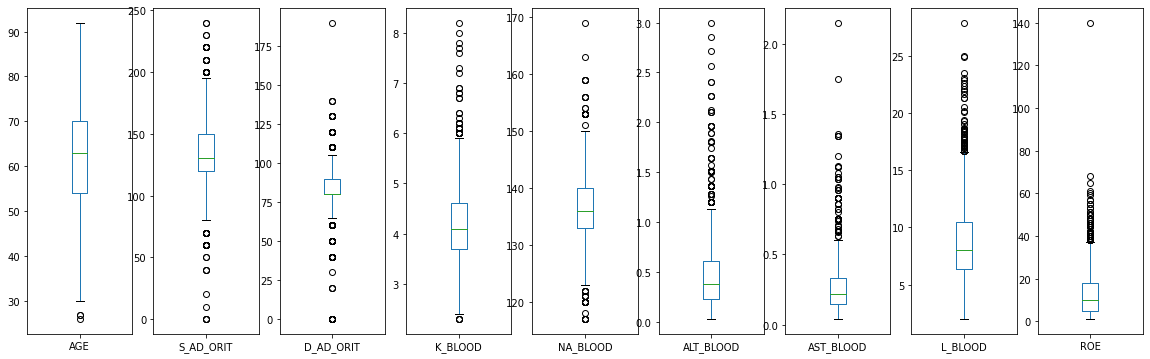

In [34]:
raw_xls[numeric_features].plot(kind='box', subplots=True, figsize=(20,6))

AGE             AxesSubplot(0.125,0.125;0.0731132x0.755)
S_AD_ORIT    AxesSubplot(0.212736,0.125;0.0731132x0.755)
D_AD_ORIT    AxesSubplot(0.300472,0.125;0.0731132x0.755)
K_BLOOD      AxesSubplot(0.388208,0.125;0.0731132x0.755)
NA_BLOOD     AxesSubplot(0.475943,0.125;0.0731132x0.755)
ALT_BLOOD    AxesSubplot(0.563679,0.125;0.0731132x0.755)
AST_BLOOD    AxesSubplot(0.651415,0.125;0.0731132x0.755)
L_BLOOD      AxesSubplot(0.739151,0.125;0.0731132x0.755)
ROE          AxesSubplot(0.826887,0.125;0.0731132x0.755)
dtype: object

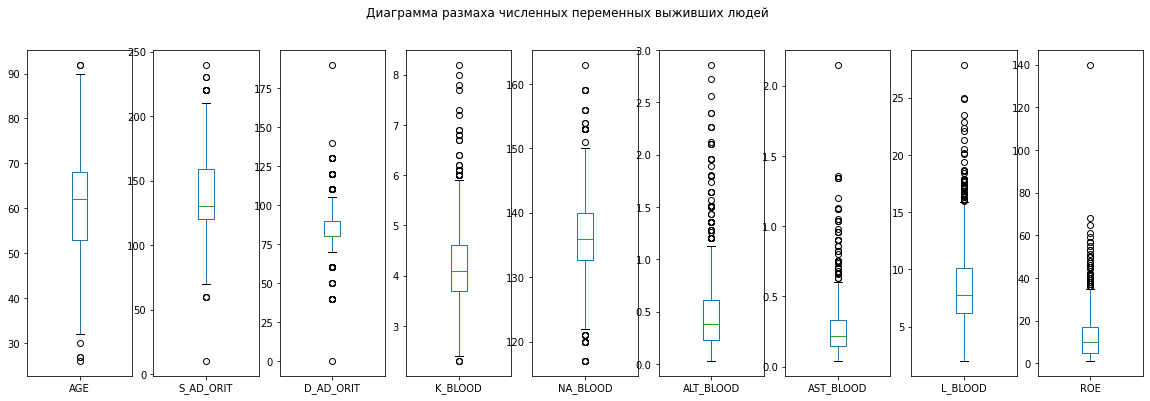

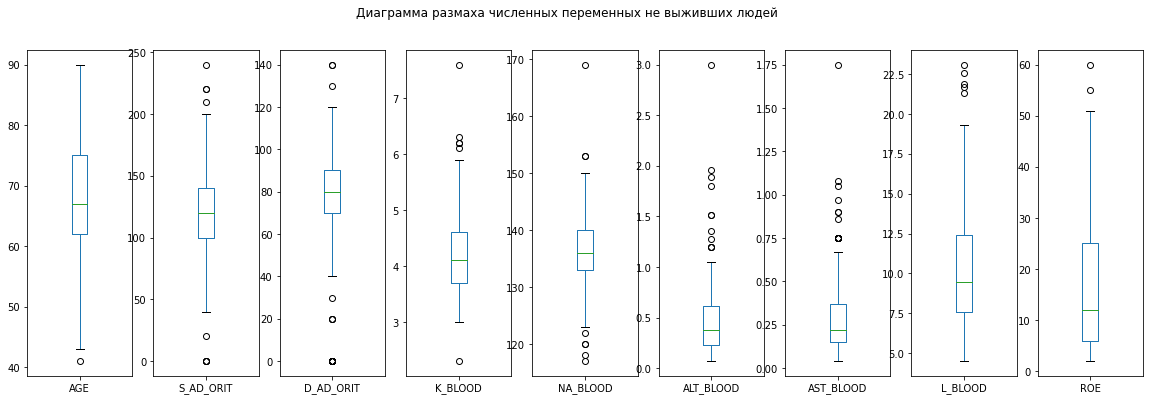

In [35]:
raw_xls[numeric_features].loc[raw_xls['LET_IS'] == 0].plot(kind='box',title = 'Диаграмма размаха численных переменных выживших людей', subplots=True, figsize=(20,6))
raw_xls[numeric_features].loc[raw_xls['LET_IS'] > 0].plot(kind='box', title = 'Диаграмма размаха численных переменных не выживших людей', subplots=True, figsize=(20,6))

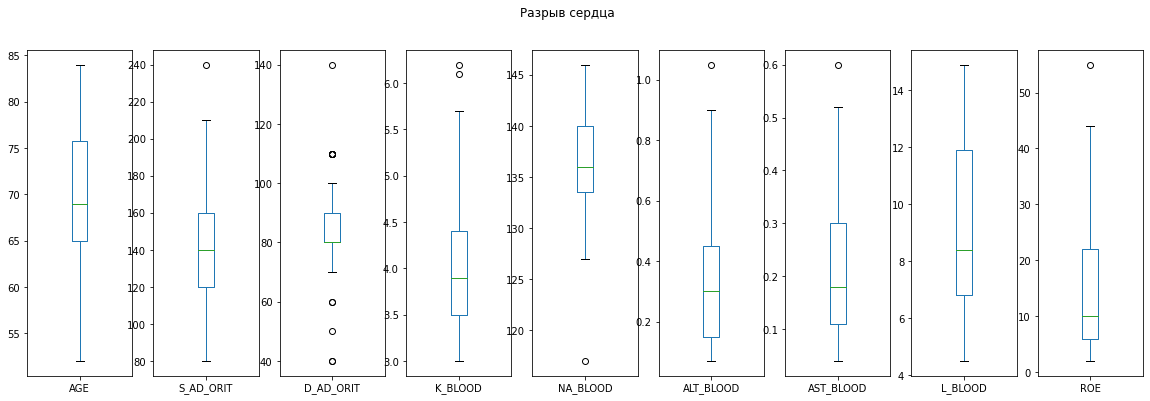

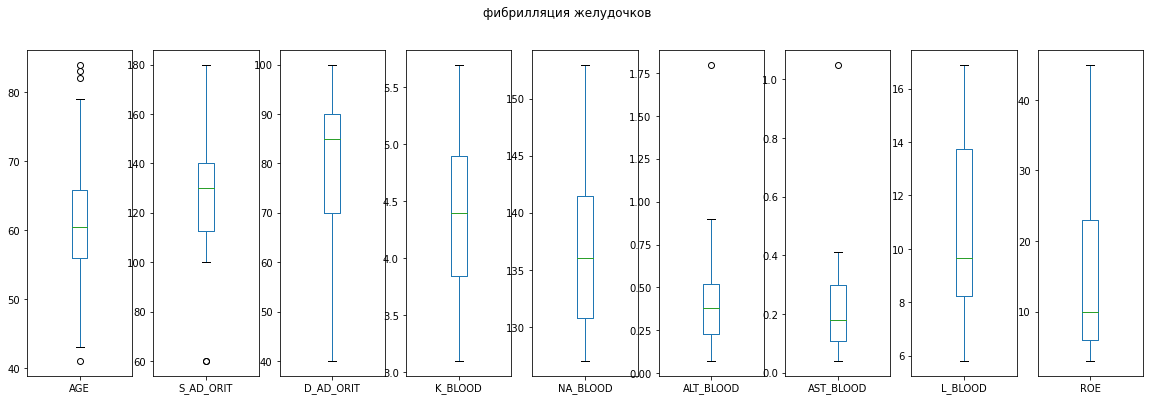

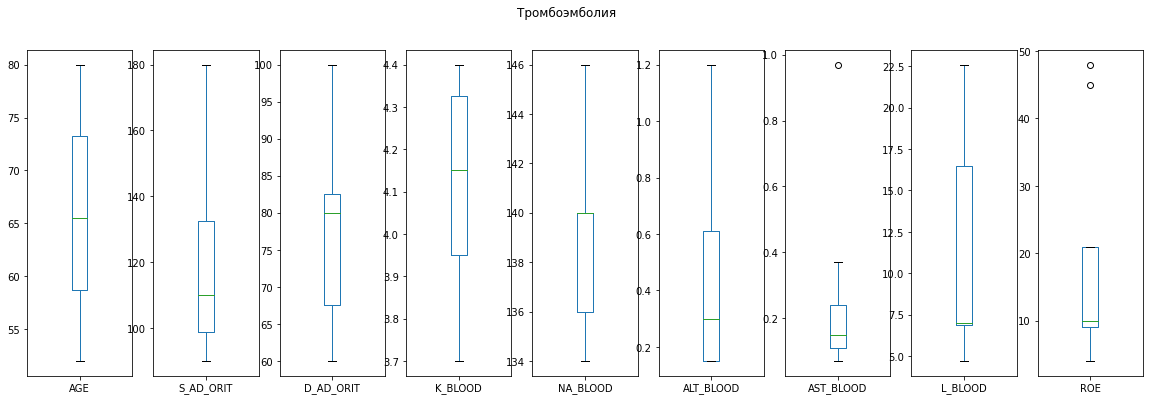

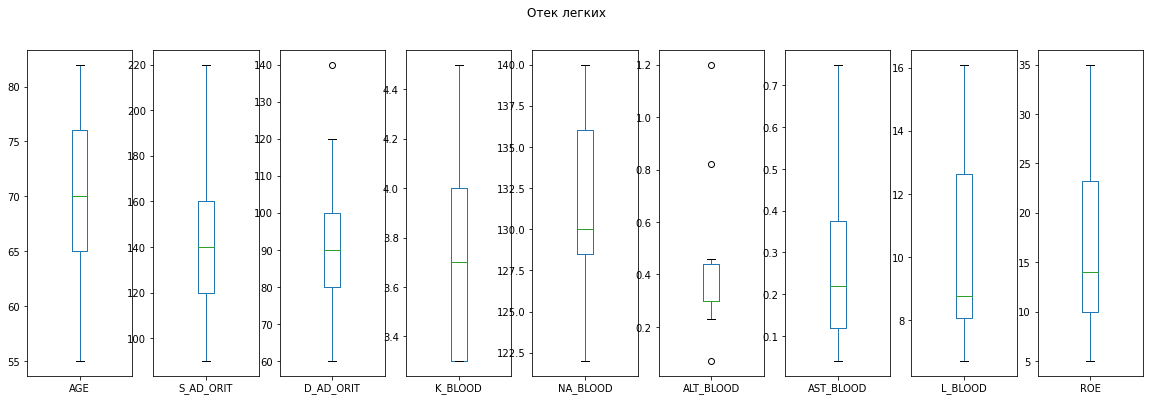

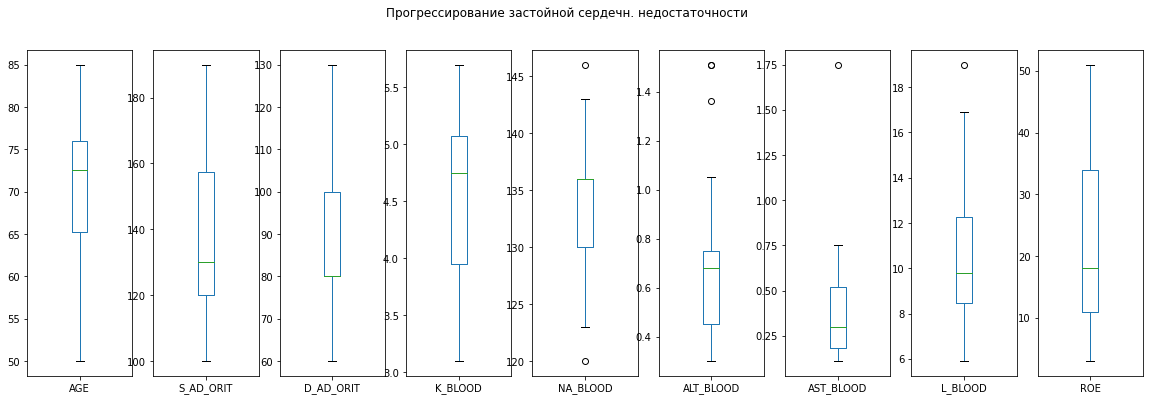

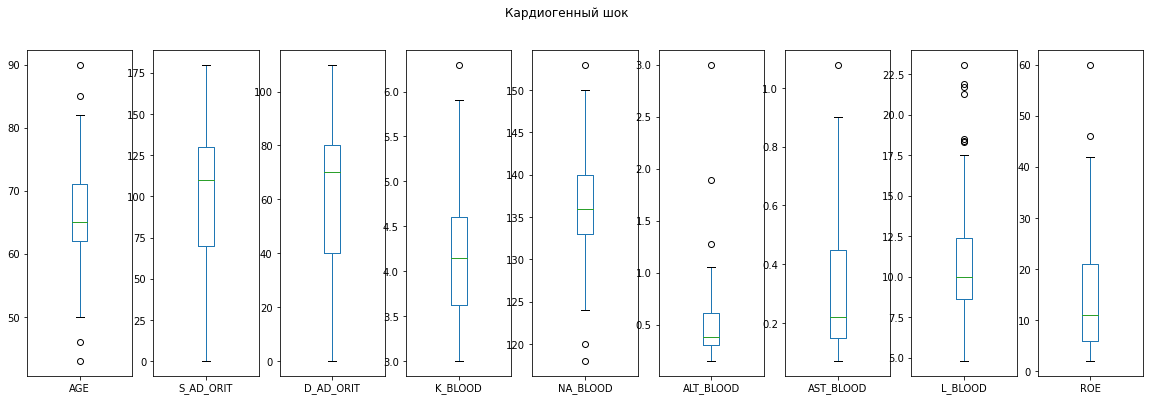

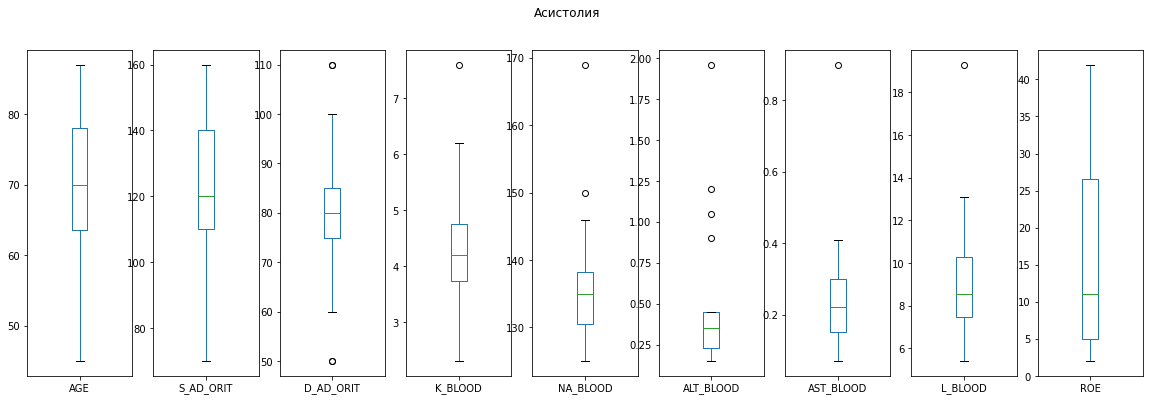

In [19]:
for i in raw_xls['LET_IS'].unique():
    if i > 0:
        raw_xls[numeric_features].loc[raw_xls['LET_IS'] == i].plot(kind='box', title = death_dict[i], subplots=True, figsize=(20,6))  

<AxesSubplot:ylabel='Frequency'>

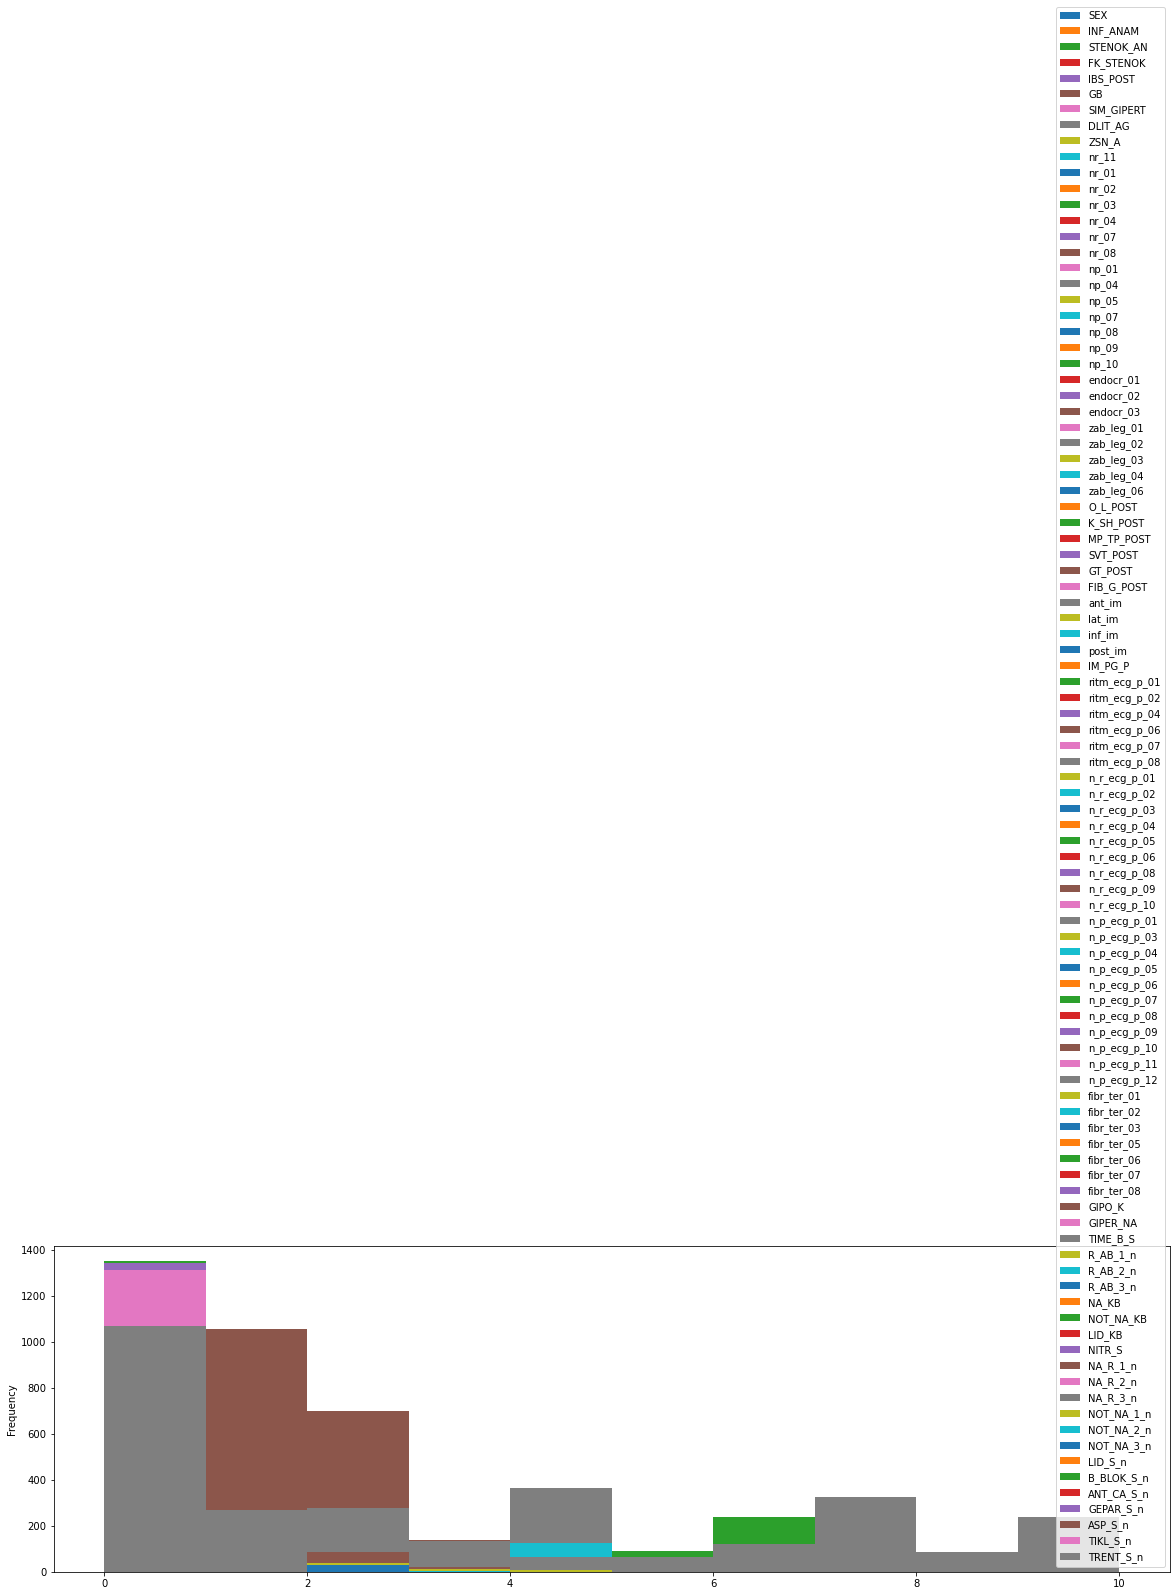

In [205]:
raw_xls[categorical_features].loc[raw_xls['LET_IS'] == 0].plot(kind='hist', figsize=(20,6)) # Переделать

TODO: построить boxplot и гистограммы по всем данным и сгруппировав по классам (по 7 и по 2)

TODO: попробовать заполнить средним, заполнить средним по классу (если известен класс)

array([<AxesSubplot:title={'center':'STENOK_AN'}>], dtype=object)

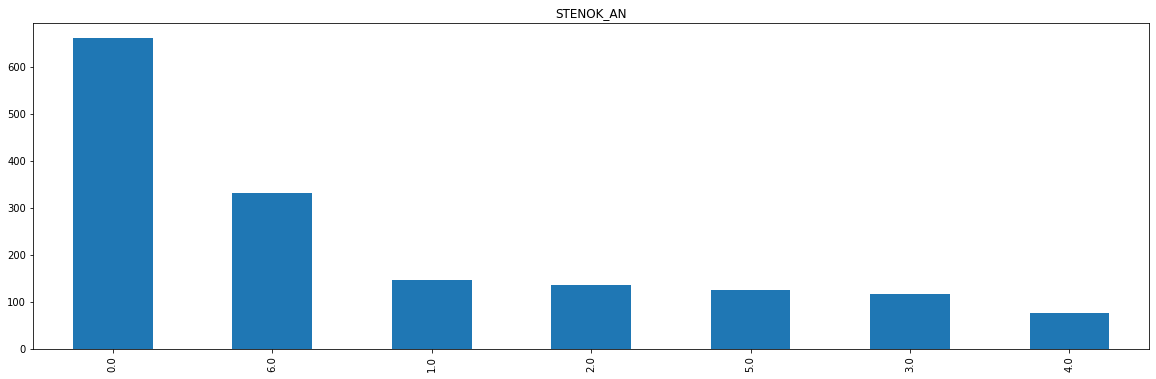

In [66]:
raw_xls[categorical_features[2]].value_counts().plot(kind='bar', subplots=True, figsize=(20,6))

TODO: выделить все бинарные

найти те, где одно из значений чаще 90% (+/-) - кандидат "на выкинуть"

для остальных построить barplot по всем и по классам (7 и 2)

Отдельно выделить не бинарные + графики

Поиск столбцов где одно из значение повторяется выше 90%

In [26]:
def low_informations (dataframe):
    num_rows = len(dataframe.index)
    low_information_cols = [] #

    for col in dataframe.columns:
        cnts = dataframe[col].value_counts(dropna=False)
        top_pct = (cnts/num_rows).iloc[0]

        if top_pct > 0.90:
            low_information_cols.append(col)
            print('{0}: {1:.5f}%'.format(col, top_pct*100))
            print(cnts)
            print()
    return low_information_cols

In [27]:

knn_zero_day_data_clear = knn_zero_day_data.copy()
knn_one_day_data_clear = knn_one_day_data.copy()
knn_two_day_data_clear = knn_two_day_data.copy()
knn_three_day_data_clear = knn_three_day_data.copy()

moda_zero_day_data_clear = moda_zero_day_data.copy()
moda_one_day_data_clear = moda_one_day_data.copy()
moda_two_day_data_clear = moda_two_day_data.copy()
moda_three_day_data_clear = moda_three_day_data.copy()

avg_zero_day_data_clear = avg_zero_day_data.copy()
avg_one_day_data_clear = avg_one_day_data.copy()
avg_two_day_data_clear = avg_two_day_data.copy()
avg_three_day_data_clear = avg_three_day_data.copy()

In [28]:
low_information_cols_zero = low_informations(knn_zero_day_data_clear)
low_information_cols_one = low_informations(knn_one_day_data_clear)
low_information_cols_two = low_informations(knn_two_day_data_clear)
low_information_cols_three = low_informations(knn_three_day_data_clear)

SIM_GIPERT: 96.89086%
0.0    1527
1.0      49
Name: SIM_GIPERT, dtype: int64

nr_11: 97.52538%
0.0    1537
1.0      39
Name: nr_11, dtype: int64

nr_01: 99.80964%
0.0    1573
1.0       3
Name: nr_01, dtype: int64

nr_02: 98.98477%
0.0    1560
1.0      16
Name: nr_02, dtype: int64

nr_03: 98.03299%
0.0    1545
1.0      31
Name: nr_03, dtype: int64

nr_04: 98.28680%
0.0    1549
1.0      27
Name: nr_04, dtype: int64

nr_07: 99.93655%
0.0    1575
1.0       1
Name: nr_07, dtype: int64

nr_08: 99.74619%
0.0    1572
1.0       4
Name: nr_08, dtype: int64

np_01: 99.87310%
0.0    1574
1.0       2
Name: np_01, dtype: int64

np_04: 99.80964%
0.0    1573
1.0       3
Name: np_04, dtype: int64

np_05: 99.36548%
0.0    1566
1.0      10
Name: np_05, dtype: int64

np_07: 99.93655%
0.0    1575
1.0       1
Name: np_07, dtype: int64

np_08: 99.68274%
0.0    1571
1.0       5
Name: np_08, dtype: int64

np_09: 99.87310%
0.0    1574
1.0       2
Name: np_09, dtype: int64

np_10: 99.80964%
0.0    1573
1.0      

Name: fibr_ter_08, dtype: int64

GIPER_NA: 95.49778%
0.0    1506
0.2      39
1.0      30
0.4       2
Name: GIPER_NA, dtype: int64

TIKL_S_n: 98.09765%
0.0    1547
1.0      29
0.2       1
Name: TIKL_S_n, dtype: int64

SIM_GIPERT: 96.89283%
0.0    1528
1.0      49
Name: SIM_GIPERT, dtype: int64

nr_11: 97.52695%
0.0    1538
1.0      39
Name: nr_11, dtype: int64

nr_01: 99.80977%
0.0    1574
1.0       3
Name: nr_01, dtype: int64

nr_02: 98.98542%
0.0    1561
1.0      16
Name: nr_02, dtype: int64

nr_03: 98.03424%
0.0    1546
1.0      31
Name: nr_03, dtype: int64

nr_04: 98.28789%
0.0    1550
1.0      27
Name: nr_04, dtype: int64

nr_07: 99.93659%
0.0    1576
1.0       1
Name: nr_07, dtype: int64

nr_08: 99.74635%
0.0    1573
1.0       4
Name: nr_08, dtype: int64

np_01: 99.87318%
0.0    1575
1.0       2
Name: np_01, dtype: int64

np_04: 99.80977%
0.0    1574
1.0       3
Name: np_04, dtype: int64

np_05: 99.36588%
0.0    1567
1.0      10
Name: np_05, dtype: int64

np_07: 99.93659%
0.0    1

fibr_ter_07: 99.62169%
0.0    1580
1.0       6
Name: fibr_ter_07, dtype: int64

fibr_ter_08: 99.87390%
0.0    1584
1.0       2
Name: fibr_ter_08, dtype: int64

GIPER_NA: 95.58638%
0.0    1516
0.2      38
1.0      30
0.4       2
Name: GIPER_NA, dtype: int64

R_AB_3_n: 92.81211%
0.0    1472
1.0      81
0.2      18
2.0      12
0.4       2
4.0       1
Name: R_AB_3_n, dtype: int64

NA_R_2_n: 91.55107%
0.0    1452
1.0      82
2.0      28
0.2      18
0.4       4
0.8       1
3.0       1
Name: NA_R_2_n, dtype: int64

NA_R_3_n: 94.95586%
0.0    1506
1.0      55
2.0      13
0.2      10
0.4       2
Name: NA_R_3_n, dtype: int64

NOT_NA_2_n: 90.54224%
0.0    1436
1.0      89
2.0      37
0.2      13
0.4       7
3.0       3
0.8       1
Name: NOT_NA_2_n, dtype: int64

NOT_NA_3_n: 93.50567%
0.0    1483
1.0      53
2.0      38
0.2       7
0.4       5
Name: NOT_NA_3_n, dtype: int64

TIKL_S_n: 98.10845%
0.0    1556
1.0      29
0.2       1
Name: TIKL_S_n, dtype: int64



In [121]:

knn_zero_day_data_clear = knn_zero_day_data.drop(low_information_cols_zero, axis=1)
knn_one_day_data_clear = knn_one_day_data.drop(low_information_cols_one, axis=1)
knn_two_day_data_clear = knn_two_day_data.drop(low_information_cols_two, axis=1)
knn_three_day_data_clear = knn_three_day_data.drop(low_information_cols_three, axis=1)

moda_zero_day_data_clear = moda_zero_day_data.drop(low_information_cols_zero, axis=1)
moda_one_day_data_clear = moda_one_day_data.drop(low_information_cols_one, axis=1)
moda_two_day_data_clear = moda_two_day_data.drop(low_information_cols_two, axis=1)
moda_three_day_data_clear = moda_three_day_data.drop(low_information_cols_three, axis=1)

avg_zero_day_data_clear = avg_zero_day_data.drop(low_information_cols_zero, axis=1)
avg_zero_day_data_clear = avg_one_day_data.drop(low_information_cols_one, axis=1)
avg_zero_day_data_clear = avg_two_day_data.drop(low_information_cols_two, axis=1) 
avg_zero_day_data_clear = avg_three_day_data.drop(low_information_cols_three, axis=1)


TODO: Можно ли кактегории с порядком перевести в числовые?!

In [50]:
moda_data_clear

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,endocr_01,...,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TRENT_S_n,FIBR_PREDS,ZSN,LET_IS,DEATH
0,49.0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,0
1,65.0,0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
2,58.0,1,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,43.0,1,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
4,49.0,1,0.0,4.0,2.0,1.0,2.0,3.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,62.0,1,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,1
1696,70.0,0,0.0,2.0,2.0,1.0,2.0,7.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1
1697,70.0,0,0.0,6.0,2.0,1.0,2.0,7.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1698,79.0,0,2.0,2.0,2.0,1.0,2.0,7.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1


Убираем поля с определением исхода болезни, оставляем только жив (0) или нет (1)

In [51]:
knn_data.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
avg_data.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
moda_data.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
knn_data_clear.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
avg_data_clear.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
moda_data_clear.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)

In [52]:
knn_data = Normalization(knn_data)
avg_data = Normalization(avg_data)
moda_data = Normalization(moda_data)
knn_data_clear = Normalization(knn_data_clear)
avg_data_clear = Normalization(avg_data_clear)
moda_data_clear = Normalization(moda_data_clear)

In [53]:
moda_data_clear

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,endocr_01,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TRENT_S_n,DEATH
0,0.348485,0.0,0.000000,0.000000,0.00,1.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.590909,0.0,0.000000,0.166667,0.25,0.5,0.666667,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,0.484848,1.0,0.000000,0.000000,0.00,1.0,0.666667,0.2,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.257576,1.0,0.666667,0.333333,0.25,1.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0.348485,1.0,0.000000,0.666667,0.25,0.5,0.666667,0.3,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,0.545455,1.0,0.000000,0.000000,0.00,0.0,0.000000,0.7,0.0,0.0,...,0.50,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1696,0.666667,0.0,0.000000,0.333333,0.25,0.5,0.666667,0.7,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1697,0.666667,0.0,0.000000,1.000000,0.25,0.5,0.666667,0.7,0.0,0.0,...,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1698,0.803030,0.0,0.333333,0.333333,0.25,0.5,0.666667,0.7,0.0,0.0,...,0.25,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [129]:
knn_zero_day_data.to_csv('../data/zero/knn_zero_day_data.csv',index = False)
avg_zero_day_data.to_csv('../data/zero/avg_zero_day_data.csv',index = False)
moda_zero_day_data.to_csv('../data/zero/moda_zero_day_data.csv',index = False)
knn_zero_day_data_clear.to_csv('../data/zero/knn_zero_day_data_clear.csv',index = False)
avg_zero_day_data_clear.to_csv('../data/zero/avg_zero_day_data_clear.csv',index = False)
moda_zero_day_data_clear.to_csv('../data/zero/moda_zero_day_data_clear.csv',index = False)

knn_one_day_data.to_csv('../data/one/knn_one_day_data.csv',index = False)
avg_one_day_data.to_csv('../data/one/avg_one_day_data.csv',index = False)
moda_one_day_data.to_csv('../data/one/moda_one_day_data.csv',index = False)
knn_one_day_data_clear.to_csv('../data/one/knn_one_day_data_clear.csv',index = False)
avg_one_day_data_clear.to_csv('../data/one/avg_one_day_data_clear.csv',index = False)
moda_one_day_data_clear.to_csv('../data/one/moda_one_day_data_clear.csv',index = False)



knn_two_day_data.to_csv('../data/two/knn_two_day_data.csv',index = False)
avg_two_day_data.to_csv('../data/two/avg_two_day_data.csv',index = False)
moda_two_day_data.to_csv('../data/two/moda_two_day_data.csv',index = False)
knn_two_day_data_clear.to_csv('../data/two/knn_two_day_data_clear.csv',index = False)
avg_two_day_data_clear.to_csv('../data/two/avg_two_day_data_clear.csv',index = False)
moda_two_day_data_clear.to_csv('../data/two/moda_two_day_data_clear.csv',index = False)


knn_three_day_data.to_csv('../data/three/knn_three_day_data.csv',index = False)
avg_three_day_data.to_csv('../data/three/avg_three_day_data.csv',index = False)
moda_three_day_data.to_csv('../data/three/moda_three_day_data.csv',index = False)
knn_three_day_data_clear.to_csv('../data/three/knn_three_day_data_clear.csv',index = False)
avg_three_day_data_clear.to_csv('../data/three/avg_three_day_data_clear.csv',index = False)
moda_three_day_data_clear.to_csv('../data/three/moda_three_day_data_clear.csv',index = False)

In [56]:
knn_data.to_csv('../data/knn_data.csv',index = False)
avg_data.to_csv('../data/avg_data.csv',index = False)
moda_data.to_csv('../data/moda_data.csv',index = False)
knn_data_clear.to_csv('../data/knn_data_clear.csv',index = False)
avg_data_clear.to_csv('../data/avg_data_clear.csv',index = False)
moda_data_clear.to_csv('../data/moda_data_clear.csv',index = False)

TODO: Результаты:

* какие выкинуть (сохранить полную и без "пустых" (несколько вариантов ?))
* варианты как заполнить с учетом распределения (несколь ко БД)

3 базы с заполнение пустых значений по следующим методам:
* средняя
* мода
* knn

из этих трех базы сделаны еще 3 базы без столбцов в которых значения повторяются чаще чем в 90% случаях

все 6 баз будут разделены на 3 дня и в итоге получается 18 баз, по 6 баз на каждый период

Глупая модель

Оценка?

* стратифицированная
* 5-10 случайных разбивок и показать статистику результатов
* Loss - кросс-энтропия, показатели - F1 + accuracy + confusion matrix


TODO: 

* линейная модель (2 классов) - посмотреть коэффициенты (важность) для масштабированных данных [0, 1]
* random forest - важность переменных
* НС (colab + TF + softmax (2 и 7) + sigmoid/ReLU) 

TODO доп: 

* PCA для числовых Глянуть объясн.дисперсию
* feature selection (2^n)

* classification report
* добавить в colab
* сделать выгрузку в файлы
* пересмотреть архитектуру
* пересмотреть ошибку
* cv grid search